In [1]:
import torch

from create_answer_vocab_threshold_3 import answer_vocab, ans2idx, global_counter

In [2]:
global_counter

Counter({'unanswerable': 69678,
         'no': 6565,
         'yes': 5488,
         'white': 3003,
         'grey': 2549,
         'black': 2418,
         'blue': 2175,
         'red': 1374,
         'brown': 951,
         'pink': 945,
         'green': 849,
         'keyboard': 816,
         'purple': 679,
         'nothing': 663,
         'soup': 627,
         'dog': 610,
         'laptop': 588,
         'phone': 541,
         'yellow': 536,
         'lotion': 451,
         'tan': 450,
         'food': 442,
         'orange': 394,
         'cell phone': 360,
         'remote': 351,
         'shampoo': 350,
         'coffee': 347,
         'chicken': 343,
         'coca cola': 336,
         'pepsi': 336,
         'corn': 329,
         'beans': 324,
         'remote control': 315,
         'wine': 315,
         '0': 313,
         'soda': 304,
         'can': 299,
         'computer': 291,
         'bottle': 290,
         'green beans': 275,
         'tv': 265,
         'water': 259,
  

In [11]:
# Save to JSON file
vocab_data = {
    'answer_vocab': answer_vocab,
    'ans2idx': ans2idx  # JSON will handle integers automatically
}
with open('answer_vocab.json', 'w') as f:
    json.dump(vocab_data, f, indent=4)

print("Vocabulary and index mapping saved to answer_vocab.json")

Vocabulary and index mapping saved to answer_vocab.json


In [35]:
len(answer_vocab)

6546

In [36]:
from VizWizDataset import VizWizDataset

## One layer

In [24]:
from VizWizAnswerModel0 import VizWizAnswerModel

In [25]:
def custom_collate_fn(batch):
    image_feats, text_feats, targets, answers = zip(*batch)

    image_feats = torch.stack(image_feats)
    text_feats = torch.stack(text_feats)
    targets = torch.stack(targets)

    # answers is a tuple of length batch_size, where each element is a list of answers
    return image_feats, text_feats, targets, answers


import json
# Load train data
with open("train.json", "r") as f:
    train_data = json.load(f)

# Load val data
with open("val.json", "r") as f:
    val_data = json.load(f)

train_dataset = VizWizDataset(train_data, answer_vocab, ans2idx,feature_dir="train_features", text_dir="train_questions" ,is_train=True)
val_dataset = VizWizDataset(val_data, answer_vocab, ans2idx, feature_dir="val_features", text_dir="val_questions", is_train=True)  # We do have answers for val
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_fn)


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 7
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_T3_l1_1.pth")
        print(f"Model saved as vizwiz_model_T3_l1_1.pth at validation accuracy f{best_val_accuracy}.")



Epoch 1/7 | Train Loss: 5.1939 | Train Acc: 0.5101 | Val Loss: 4.3256 | Val Acc: 0.5930
Model saved as vizwiz_model_T3_l1_1.pth at validation accuracy f0.5930385120012357.
Epoch 2/7 | Train Loss: 3.2971 | Train Acc: 0.5886 | Val Loss: 4.0298 | Val Acc: 0.6182
Model saved as vizwiz_model_T3_l1_1.pth at validation accuracy f0.6181986570965513.
Epoch 3/7 | Train Loss: 2.3126 | Train Acc: 0.6733 | Val Loss: 3.9360 | Val Acc: 0.6308
Model saved as vizwiz_model_T3_l1_1.pth at validation accuracy f0.6307787296442091.
Epoch 4/7 | Train Loss: 1.7901 | Train Acc: 0.7843 | Val Loss: 3.9647 | Val Acc: 0.6339
Model saved as vizwiz_model_T3_l1_1.pth at validation accuracy f0.6338658640117318.
Epoch 5/7 | Train Loss: 1.5813 | Train Acc: 0.8208 | Val Loss: 4.0217 | Val Acc: 0.6343
Model saved as vizwiz_model_T3_l1_1.pth at validation accuracy f0.6343289341668606.
Epoch 6/7 | Train Loss: 1.4819 | Train Acc: 0.8367 | Val Loss: 4.0957 | Val Acc: 0.6363
Model saved as vizwiz_model_T3_l1_1.pth at validatio

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_T3_l1_2.pth")
        print(f"Model saved as vizwiz_model_T3_l1_2.pth at validation accuracy f{best_val_accuracy}.")



Epoch 1/20 | Train Loss: 5.2193 | Train Acc: 0.5048 | Val Loss: 4.3352 | Val Acc: 0.6001
Model saved as vizwiz_model_T3_l1_2.pth at validation accuracy f0.6001389210465398.
Epoch 2/20 | Train Loss: 3.3001 | Train Acc: 0.5879 | Val Loss: 4.0399 | Val Acc: 0.6215
Model saved as vizwiz_model_T3_l1_2.pth at validation accuracy f0.6215173265416385.
Epoch 3/20 | Train Loss: 2.3135 | Train Acc: 0.6757 | Val Loss: 3.9317 | Val Acc: 0.6268
Model saved as vizwiz_model_T3_l1_2.pth at validation accuracy f0.6267654549664281.
Epoch 4/20 | Train Loss: 1.7943 | Train Acc: 0.7812 | Val Loss: 3.9717 | Val Acc: 0.6327
Model saved as vizwiz_model_T3_l1_2.pth at validation accuracy f0.6327081886239104.
Epoch 5/20 | Train Loss: 1.5824 | Train Acc: 0.8204 | Val Loss: 4.0266 | Val Acc: 0.6387
Model saved as vizwiz_model_T3_l1_2.pth at validation accuracy f0.6387281006405813.
Epoch 6/20 | Train Loss: 1.4774 | Train Acc: 0.8395 | Val Loss: 4.1045 | Val Acc: 0.6369
Epoch 7/20 | Train Loss: 1.4235 | Train Acc: 0

## Two layer`

In [41]:
from VizWizAnswerModel import VizWizAnswerModel

In [38]:
from VizWizAnswerModel_wod import VizWizAnswerModel

In [42]:
def custom_collate_fn(batch):
    image_feats, text_feats, targets, answers = zip(*batch)

    image_feats = torch.stack(image_feats)
    text_feats = torch.stack(text_feats)
    targets = torch.stack(targets)

    # answers is a tuple of length batch_size, where each element is a list of answers
    return image_feats, text_feats, targets, answers


import json
# Load train data
with open("train.json", "r") as f:
    train_data = json.load(f)

# Load val data
with open("val.json", "r") as f:
    val_data = json.load(f)

train_dataset = VizWizDataset(train_data, answer_vocab, ans2idx,feature_dir="train_features", text_dir="train_questions" ,is_train=True)
val_dataset = VizWizDataset(val_data, answer_vocab, ans2idx, feature_dir="val_features", text_dir="val_questions", is_train=True)  # We do have answers for val
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_fn)




In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 7
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_T3_4.pth")
        print(f"Model saved as vizwiz_model_T3_4.pth at validation accuracy f{best_val_accuracy}.")



/home/radheshyamrouth/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch 1/7 | Train Loss: 5.1207 | Train Acc: 0.5086 | Val Loss: 4.2731 | Val Acc: 0.5901
Model saved as vizwiz_model_T3_4.pth at validation accuracy f0.5901057343520879.
Epoch 2/7 | Train Loss: 4.0683 | Train Acc: 0.5555 | Val Loss: 4.0409 | Val Acc: 0.6060
Model saved as vizwiz_model_T3_4.pth at validation accuracy f0.6060044763448338.
Epoch 3/7 | Train Loss: 3.4923 | Train Acc: 0.5827 | Val Loss: 3.9728 | Val Acc: 0.6201
Model saved as vizwiz_model_T3_4.pth at validation accuracy f0.620050937717065.
Epoch 4/7 | Train Loss: 3.0035 | Train Acc: 0.6140 | Val Loss: 3.9598 | Val Acc: 0.6206
Model saved as vizwiz_model_T3_4.pth at validation accuracy f0.6205911862313817.
Epoch 5/7 | Train Loss: 2.5839 | Train Acc: 0.6456 | Val Loss: 3.9605 | Val Acc: 0.6281
Model saved as vizwiz_model_T3_4.pth at validation accuracy f0.6280774870726256.
Epoch 6/7 | Train Loss: 2.2361 | Train Acc: 0.6809 | Val Loss: 4.0277 | Val Acc: 0.6340
Model saved as vizwiz_model_T3_4.pth at validation accuracy f0.63402

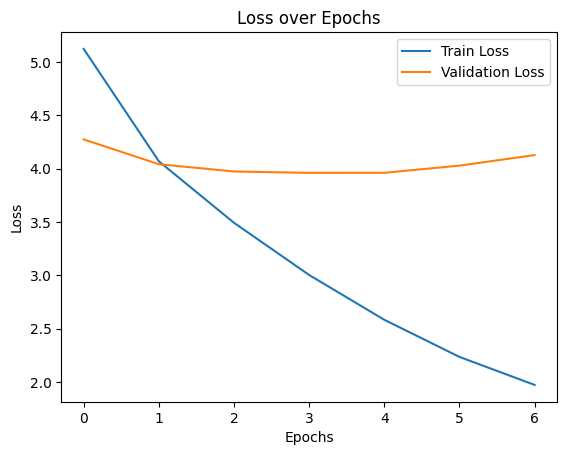

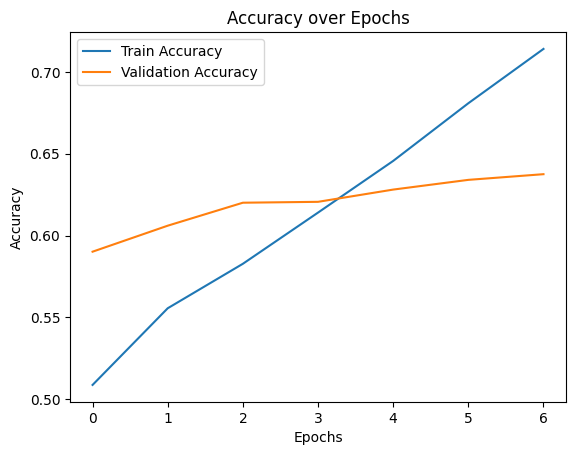

In [9]:
import matplotlib.pyplot as plt

# Loss Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy Plot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 30
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_T3_10.pth")
        print(f"Model saved as vizwiz_model_T3_10.pth at validation accuracy f{best_val_accuracy}.")



Epoch 1/30 | Train Loss: 5.1214 | Train Acc: 0.5057 | Val Loss: 4.2676 | Val Acc: 0.6015
Model saved as vizwiz_model_T3_10.pth at validation accuracy f0.601528131511925.
Epoch 2/30 | Train Loss: 4.0643 | Train Acc: 0.5545 | Val Loss: 4.0567 | Val Acc: 0.6112
Model saved as vizwiz_model_T3_10.pth at validation accuracy f0.6111754264104352.
Epoch 3/30 | Train Loss: 3.4936 | Train Acc: 0.5820 | Val Loss: 3.9540 | Val Acc: 0.6173
Model saved as vizwiz_model_T3_10.pth at validation accuracy f0.6172725167862941.
Epoch 4/30 | Train Loss: 3.0000 | Train Acc: 0.6119 | Val Loss: 3.9277 | Val Acc: 0.6240
Model saved as vizwiz_model_T3_10.pth at validation accuracy f0.623987034035657.
Epoch 5/30 | Train Loss: 2.5857 | Train Acc: 0.6453 | Val Loss: 3.9395 | Val Acc: 0.6284
Model saved as vizwiz_model_T3_10.pth at validation accuracy f0.6283862005093775.
Epoch 6/30 | Train Loss: 2.2346 | Train Acc: 0.6809 | Val Loss: 4.0065 | Val Acc: 0.6278
Epoch 7/30 | Train Loss: 1.9731 | Train Acc: 0.7149 | Val 

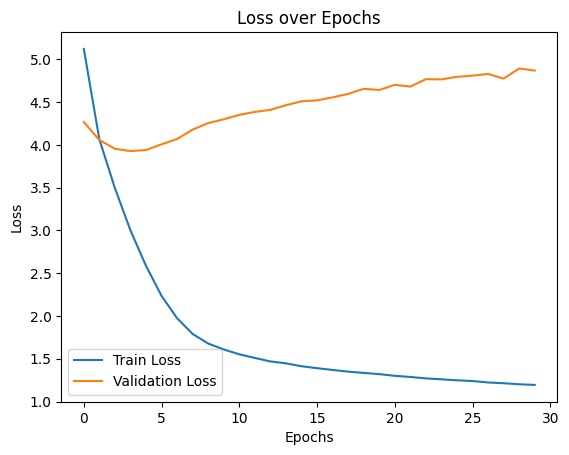

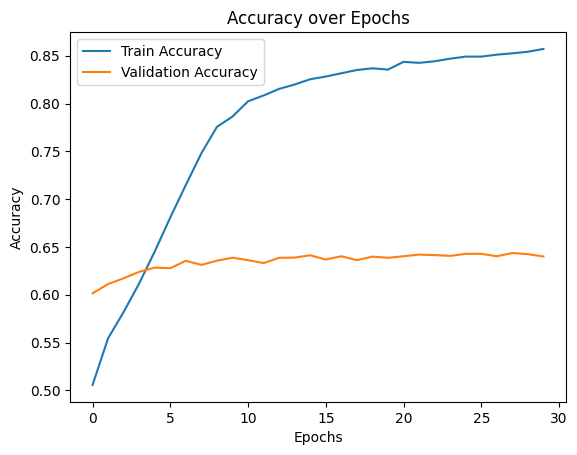

In [44]:
import matplotlib.pyplot as plt

# Loss Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_plot2.png")  # Save the loss plot
plt.show()

# Accuracy Plot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_plot2.png")  # Save the accuracy plot
plt.show()


In [77]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_T3_2.pth")
        print(f"Model saved as vizwiz_model_T3_2.pth at validation accuracy f{best_val_accuracy}.")

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")



Model saved as vizwiz_model_T3_2.pth at validation accuracy f0.5938102955931164.
Epoch 1/10 | Train Loss: 5.1096 | Train Acc: 0.5078 | Val Loss: 4.2554 | Val Acc: 0.5938
Model saved as vizwiz_model_T3_2.pth at validation accuracy f0.609014432353169.
Epoch 2/10 | Train Loss: 4.0716 | Train Acc: 0.5573 | Val Loss: 4.0753 | Val Acc: 0.6090
Model saved as vizwiz_model_T3_2.pth at validation accuracy f0.6192791541251842.
Epoch 3/10 | Train Loss: 3.5002 | Train Acc: 0.5828 | Val Loss: 3.9565 | Val Acc: 0.6193
Model saved as vizwiz_model_T3_2.pth at validation accuracy f0.6248359959867259.
Epoch 4/10 | Train Loss: 3.0209 | Train Acc: 0.6104 | Val Loss: 3.9109 | Val Acc: 0.6248
Model saved as vizwiz_model_T3_2.pth at validation accuracy f0.6266882766072398.
Epoch 5/10 | Train Loss: 2.5960 | Train Acc: 0.6456 | Val Loss: 3.9341 | Val Acc: 0.6267
Model saved as vizwiz_model_T3_2.pth at validation accuracy f0.6374932468935713.
Epoch 6/10 | Train Loss: 2.2470 | Train Acc: 0.6771 | Val Loss: 4.0303

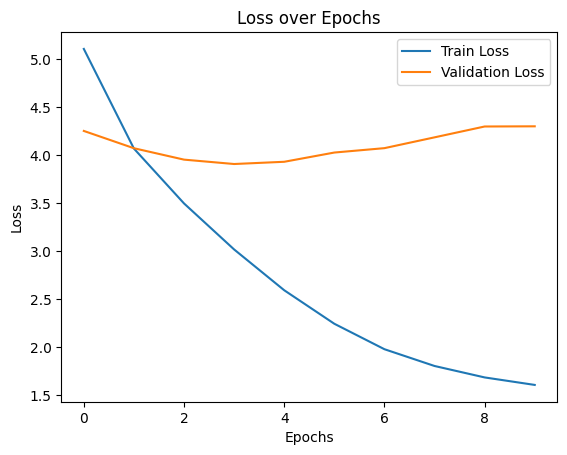

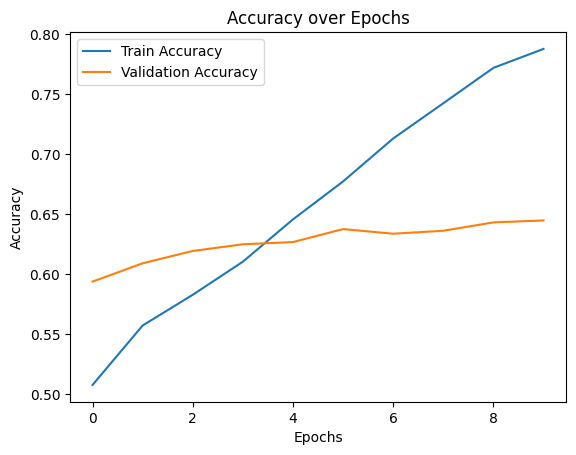

In [78]:
import matplotlib.pyplot as plt

# Loss Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy Plot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

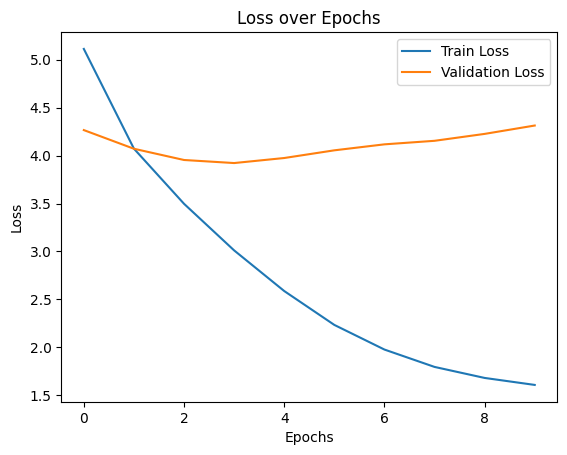

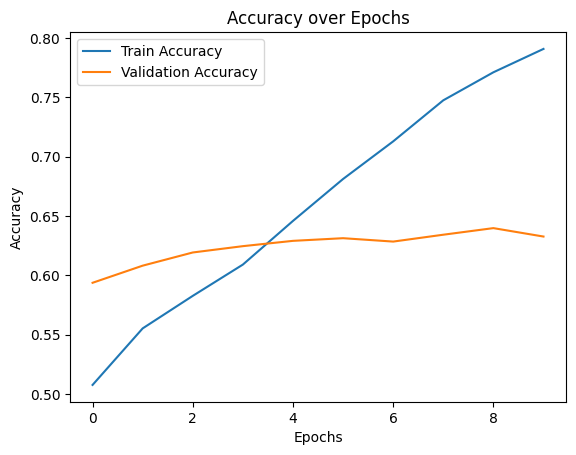

In [76]:
import matplotlib.pyplot as plt

# Loss Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy Plot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
# Save the model
torch.save(model.state_dict(), "vizwiz_model_T3_0.pth")
print("Model saved as vizwiz_model_T3_0.pth")


/home/radheshyamrouth/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch 1/20 | Train Loss: 5.1186 | Train Acc: 0.5065 | Val Loss: 4.2535 | Val Acc: 0.5970
Epoch 2/20 | Train Loss: 4.0688 | Train Acc: 0.5544 | Val Loss: 4.0470 | Val Acc: 0.6120
Epoch 3/20 | Train Loss: 3.4897 | Train Acc: 0.5817 | Val Loss: 3.9333 | Val Acc: 0.6159
Epoch 4/20 | Train Loss: 3.0086 | Train Acc: 0.6108 | Val Loss: 3.9331 | Val Acc: 0.6238
Epoch 5/20 | Train Loss: 2.5713 | Train Acc: 0.6416 | Val Loss: 3.9253 | Val Acc: 0.6318
Epoch 6/20 | Train Loss: 2.2392 | Train Acc: 0.6794 | Val Loss: 3.9959 | Val Acc: 0.6327
Epoch 7/20 | Train Loss: 1.9704 | Train Acc: 0.7150 | Val Loss: 4.0952 | Val Acc: 0.6343
Epoch 8/20 | Train Loss: 1.7911 | Train Acc: 0.7447 | Val Loss: 4.1500 | Val Acc: 0.6425
Epoch 9/20 | Train Loss: 1.6819 | Train Acc: 0.7703 | Val Loss: 4.2923 | Val Acc: 0.6351
Epoch 10/20 | Train Loss: 1.6057 | Train Acc: 0.7885 | Val Loss: 4.3135 | Val Acc: 0.6414
Epoch 11/20 | Train Loss: 1.5461 | Train Acc: 0.8032 | Val Loss: 4.3899 | Val Acc: 0.6417
Epoch 12/20 | Train

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
# Save the model
torch.save(model.state_dict(), "vizwiz_model_T3_1.pth")
print("Model saved as vizwiz_model_T3_1.pth")


Epoch 1/50 | Train Loss: 5.1122 | Train Acc: 0.5066 | Val Loss: 4.2505 | Val Acc: 0.5964
Epoch 2/50 | Train Loss: 4.0670 | Train Acc: 0.5552 | Val Loss: 4.0674 | Val Acc: 0.6130
Epoch 3/50 | Train Loss: 3.4960 | Train Acc: 0.5839 | Val Loss: 3.9656 | Val Acc: 0.6211
Epoch 4/50 | Train Loss: 3.0159 | Train Acc: 0.6082 | Val Loss: 3.9394 | Val Acc: 0.6265
Epoch 5/50 | Train Loss: 2.5806 | Train Acc: 0.6431 | Val Loss: 3.9510 | Val Acc: 0.6316
Epoch 6/50 | Train Loss: 2.2382 | Train Acc: 0.6810 | Val Loss: 4.0026 | Val Acc: 0.6329
Epoch 7/50 | Train Loss: 1.9795 | Train Acc: 0.7129 | Val Loss: 4.0882 | Val Acc: 0.6363
Epoch 8/50 | Train Loss: 1.8000 | Train Acc: 0.7439 | Val Loss: 4.2022 | Val Acc: 0.6387
Epoch 9/50 | Train Loss: 1.6799 | Train Acc: 0.7719 | Val Loss: 4.2768 | Val Acc: 0.6407
Epoch 10/50 | Train Loss: 1.6030 | Train Acc: 0.7905 | Val Loss: 4.3220 | Val Acc: 0.6418
Epoch 11/50 | Train Loss: 1.5523 | Train Acc: 0.8003 | Val Loss: 4.3704 | Val Acc: 0.6415
Epoch 12/50 | Train

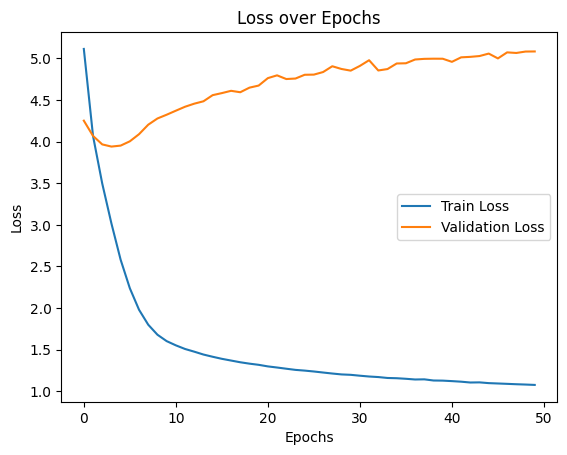

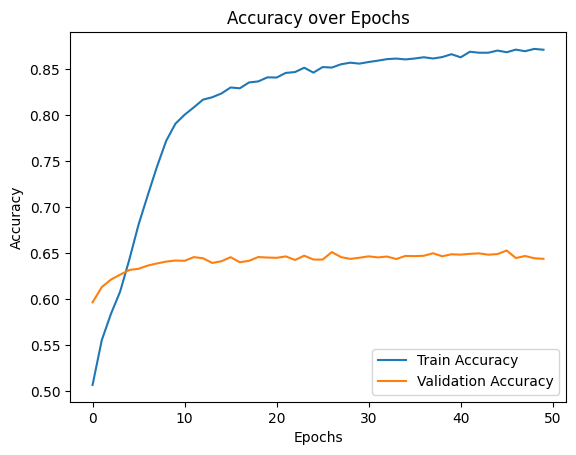

In [73]:
import matplotlib.pyplot as plt

# Loss Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy Plot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### No dropout

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 30
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_Tl2_4.pth")
        print(f"Model saved as vizwiz_model_Tl2_4.pth at validation accuracy f{best_val_accuracy}.")



Epoch 1/30 | Train Loss: 4.7532 | Train Acc: 0.5254 | Val Loss: 4.0101 | Val Acc: 0.6052
Model saved as vizwiz_model_Tl2_4.pth at validation accuracy f0.6051555143937656.
Epoch 2/30 | Train Loss: 2.8266 | Train Acc: 0.6210 | Val Loss: 3.8643 | Val Acc: 0.6164
Model saved as vizwiz_model_Tl2_4.pth at validation accuracy f0.6164235548352247.
Epoch 3/30 | Train Loss: 1.8165 | Train Acc: 0.7416 | Val Loss: 3.9950 | Val Acc: 0.6122
Epoch 4/30 | Train Loss: 1.4366 | Train Acc: 0.8305 | Val Loss: 4.1385 | Val Acc: 0.6100
Epoch 5/30 | Train Loss: 1.3303 | Train Acc: 0.8508 | Val Loss: 4.3056 | Val Acc: 0.6212
Model saved as vizwiz_model_Tl2_4.pth at validation accuracy f0.6212086131048864.
Epoch 6/30 | Train Loss: 1.2677 | Train Acc: 0.8619 | Val Loss: 4.3227 | Val Acc: 0.6234
Model saved as vizwiz_model_Tl2_4.pth at validation accuracy f0.6233696071621526.
Epoch 7/30 | Train Loss: 1.2079 | Train Acc: 0.8668 | Val Loss: 4.3244 | Val Acc: 0.6204
Epoch 8/30 | Train Loss: 1.1628 | Train Acc: 0.87

## Three Layer`

In [21]:
from VizWizAnswerModel1 import VizWizAnswerModel

In [22]:
def custom_collate_fn(batch):
    image_feats, text_feats, targets, answers = zip(*batch)

    image_feats = torch.stack(image_feats)
    text_feats = torch.stack(text_feats)
    targets = torch.stack(targets)

    # answers is a tuple of length batch_size, where each element is a list of answers
    return image_feats, text_feats, targets, answers


import json
# Load train data
with open("train.json", "r") as f:
    train_data = json.load(f)

# Load val data
with open("val.json", "r") as f:
    val_data = json.load(f)

train_dataset = VizWizDataset(train_data, answer_vocab, ans2idx,feature_dir="train_features", text_dir="train_questions" ,is_train=True)
val_dataset = VizWizDataset(val_data, answer_vocab, ans2idx, feature_dir="val_features", text_dir="val_questions", is_train=True)  # We do have answers for val
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_fn)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)


In [19]:

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 7
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_T3_l3_1.pth")
        print(f"Model saved as vizwiz_model_T3_l3_1.pth at validation accuracy f{best_val_accuracy}.")



Epoch 1/7 | Train Loss: 5.1634 | Train Acc: 0.4903 | Val Loss: 4.4499 | Val Acc: 0.5808
Model saved as vizwiz_model_T3_l3_1.pth at validation accuracy f0.5807671528903305.
Epoch 2/7 | Train Loss: 4.1228 | Train Acc: 0.5281 | Val Loss: 4.1648 | Val Acc: 0.5933
Model saved as vizwiz_model_T3_l3_1.pth at validation accuracy f0.5932700470788003.
Epoch 3/7 | Train Loss: 3.6200 | Train Acc: 0.5479 | Val Loss: 4.0851 | Val Acc: 0.5945
Model saved as vizwiz_model_T3_l3_1.pth at validation accuracy f0.5945049008258099.
Epoch 4/7 | Train Loss: 3.2047 | Train Acc: 0.5622 | Val Loss: 4.1569 | Val Acc: 0.5822
Epoch 5/7 | Train Loss: 2.8669 | Train Acc: 0.5836 | Val Loss: 4.1774 | Val Acc: 0.5864
Epoch 6/7 | Train Loss: 2.5740 | Train Acc: 0.6085 | Val Loss: 4.3443 | Val Acc: 0.5619
Epoch 7/7 | Train Loss: 2.3463 | Train Acc: 0.6468 | Val Loss: 4.4109 | Val Acc: 0.5501


##### No drop out in the mid layer

In [20]:

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_T3_l3_2.pth")
        print(f"Model saved as vizwiz_model_T3_l3_2.pth at validation accuracy f{best_val_accuracy}.")



Epoch 1/20 | Train Loss: 2.2002 | Train Acc: 0.6754 | Val Loss: 4.4908 | Val Acc: 0.5405
Model saved as vizwiz_model_T3_l3_2.pth at validation accuracy f0.5404800493941505.
Epoch 2/20 | Train Loss: 2.0894 | Train Acc: 0.6969 | Val Loss: 4.5808 | Val Acc: 0.5362
Epoch 3/20 | Train Loss: 2.0018 | Train Acc: 0.7159 | Val Loss: 4.6129 | Val Acc: 0.5413
Model saved as vizwiz_model_T3_l3_2.pth at validation accuracy f0.541251832986031.
Epoch 4/20 | Train Loss: 1.9323 | Train Acc: 0.7299 | Val Loss: 4.6275 | Val Acc: 0.5365
Epoch 5/20 | Train Loss: 1.8711 | Train Acc: 0.7420 | Val Loss: 4.7357 | Val Acc: 0.5197
Epoch 6/20 | Train Loss: 1.8354 | Train Acc: 0.7489 | Val Loss: 4.6948 | Val Acc: 0.5382
Epoch 7/20 | Train Loss: 1.7830 | Train Acc: 0.7588 | Val Loss: 4.7191 | Val Acc: 0.5398
Epoch 8/20 | Train Loss: 1.7499 | Train Acc: 0.7671 | Val Loss: 4.7815 | Val Acc: 0.5230
Epoch 9/20 | Train Loss: 1.7150 | Train Acc: 0.7731 | Val Loss: 4.7029 | Val Acc: 0.5555
Model saved as vizwiz_model_T3_l

In [23]:

# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_T3_l3_3.pth")
        print(f"Model saved as vizwiz_model_T3_l3_3.pth at validation accuracy f{best_val_accuracy}.")



Epoch 1/20 | Train Loss: 5.1753 | Train Acc: 0.4867 | Val Loss: 4.4031 | Val Acc: 0.5737
Model saved as vizwiz_model_T3_l3_3.pth at validation accuracy f0.5737439222042143.
Epoch 2/20 | Train Loss: 4.1224 | Train Acc: 0.5307 | Val Loss: 4.1788 | Val Acc: 0.5957
Model saved as vizwiz_model_T3_l3_3.pth at validation accuracy f0.5957397545728188.
Epoch 3/20 | Train Loss: 3.6190 | Train Acc: 0.5499 | Val Loss: 4.1281 | Val Acc: 0.5969
Model saved as vizwiz_model_T3_l3_3.pth at validation accuracy f0.5968974299606405.
Epoch 4/20 | Train Loss: 3.2085 | Train Acc: 0.5664 | Val Loss: 4.1312 | Val Acc: 0.5876
Epoch 5/20 | Train Loss: 2.8528 | Train Acc: 0.5839 | Val Loss: 4.2832 | Val Acc: 0.5553
Epoch 6/20 | Train Loss: 2.5705 | Train Acc: 0.6105 | Val Loss: 4.3785 | Val Acc: 0.5547
Epoch 7/20 | Train Loss: 2.3512 | Train Acc: 0.6444 | Val Loss: 4.4426 | Val Acc: 0.5561
Epoch 8/20 | Train Loss: 2.1991 | Train Acc: 0.6734 | Val Loss: 4.5314 | Val Acc: 0.5457
Epoch 9/20 | Train Loss: 2.0822 | Tr